# <b> <center> <font color='#7B241C'> GRAD-CAM </font> </center> </b>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Load a pre-trained model and an example image](#3)
4. [Compute Grad-CAM and visualization](#4)
5. [References](#references)

<a name="1"></a>
## <b> <font color='red'> 1. Introduction </font> </b>

This notebook demonstrates how to generate and visualize Gradient-weighted Class Activation Maps (Grad-CAM). Grad-CAM is a powerful technique that uses the gradients of a target class flowing into the final convolutional layer of a CNN to produce a coarse localization map. This highlights the important regions in the input image that influence the model’s prediction.

We will apply Grad-CAM to a pretrained model to better understand what the model is focusing on when making classification decisions.

<a name="2"></a>
## <b> <font color='red'> 2. Setup </font> </b>

In [2]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

<a name="3"></a>
## <b> <font color='red'> 3. Load a pre-trained model and an example image </font> </b>

As model, we will use ResNet18.

In [4]:
model = models.resnet18(pretrained=True).eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now let's load an image and write a function to preprocess it according to the model's requirements.

In [5]:
# Load an image
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2025-06-04 19:15:21--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolviendo cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Conectando con cdn.pixabay.com (cdn.pixabay.com)[104.18.40.96]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 215472 (210K) [image/jpeg]
Guardando como: ‘image.jpg’

image.jpg           100%[===================>] 210,42K  --.-KB/s    en 0,03s   

2025-06-04 19:15:21 (6,52 MB/s) - ‘image.jpg’ guardado [215472/215472]



In [6]:
# -----------------------------
# Preprocessing
# -----------------------------
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    img = Image.open(img_path).convert('RGB')
    tensor = transform(img).unsqueeze(0)
    return img, tensor


<a name="4"></a>
## <b> <font color='red'> 4. Compute Grad-CAM and visualization </font> </b>

In [8]:
# -----------------------------
# Grad-CAM core class
# -----------------------------
class GradCAM:
    """
    Grad-CAM implementation to generate class activation maps for a given CNN model and target convolutional layer.

    Args:
        model (torch.nn.Module): The pretrained CNN model.
        target_layer (torch.nn.Module): The convolutional layer for which Grad-CAM is computed.

    Attributes:
        activations (Tensor): Stores the forward activations from the target layer.
        gradients (Tensor): Stores the gradients of the target layer w.r.t. the target class score.
    """

    def __init__(self, model, target_layer):
        self.model = model.eval()  # Set model to evaluation mode
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Register forward and backward hooks on the target layer
        self._register_hooks()

    def _register_hooks(self):
        """
        Register hooks to capture the activations and gradients from the target layer during forward and backward passes.
        """
        def forward_hook(module, input, output):
            # Store forward pass activations
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            # Store gradients from the backward pass
            # grad_output is a tuple; first element corresponds to gradients w.r.t. the output
            self.gradients = grad_output[0].detach()

        # Attach hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        """
        Generates the Grad-CAM heatmap for the specified class index.

        Args:
            input_tensor (Tensor): Input image tensor, shape [B, C, H, W].
            class_idx (int, optional): Target class index. If None, uses the predicted class.

        Returns:
            cam (ndarray): Normalized Grad-CAM heatmap as a numpy array.
            class_idx (int): The class index used for Grad-CAM generation.
        """
        # Forward pass
        output = self.model(input_tensor)

        # If no target class specified, use the class with highest score
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero existing gradients
        self.model.zero_grad()

        # Backward pass on the output score corresponding to the target class
        loss = output[0, class_idx]
        loss.backward()

        # Get stored gradients and activations from hooks
        gradients = self.gradients  # Shape: [B, C, H, W]
        activations = self.activations  # Shape: [B, C, H, W]

        # Global average pool the gradients across spatial dimensions (H, W)
        pooled_grads = torch.mean(gradients, dim=(2, 3))  # Shape: [B, C]

        # Initialize the CAM with zeros, same spatial size as activations
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32)

        # Weighted sum of the activations by their corresponding pooled gradients
        for i in range(activations.shape[1]):
            cam += pooled_grads[0, i] * activations[0, i]

        # Apply ReLU to keep only positive influence regions
        cam = F.relu(cam)

        # Normalize the CAM to range [0, 1]
        cam -= cam.min()
        cam /= cam.max() + 1e-8  # Avoid division by zero

        return cam.cpu().numpy(), class_idx


Let's visualize:

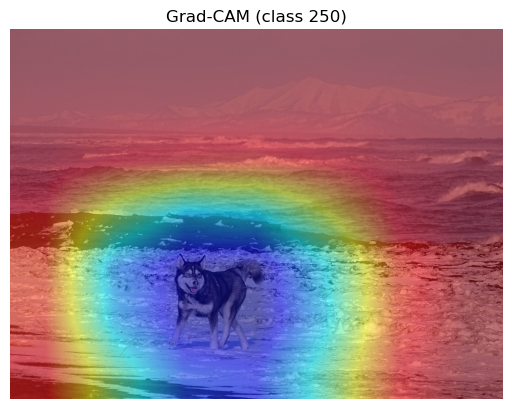

In [11]:
# -----------------------------
# Visualize CAM
# -----------------------------
def overlay_cam(img, cam, alpha=0.5):
    cam = cv2.resize(cam, (img.width, img.height))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_np = np.array(img)
    overlay = heatmap * alpha + img_np * (1 - alpha)
    return overlay.astype(np.uint8)

# -----------------------------
# Example usage
# -----------------------------
def grad_cam_demo(model, img_path):
    target_layer = model.layer4[-1]

    img, input_tensor = preprocess_image(img_path)
    grad_cam = GradCAM(model, target_layer)
    cam, class_idx = grad_cam.generate(input_tensor)

    overlay = overlay_cam(img, cam)

    # Show or save result
    plt.imshow(overlay)
    plt.title(f"Grad-CAM (class {class_idx})")
    plt.axis('off')
    plt.show()

# Call with your image path
grad_cam_demo(model, "image.jpg")

<a name="references"></a>
## <b> <font color='red'> References </font> </b>

[TensorFlow: Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)